In [41]:
import os
import numpy as np
import h5py
import pandas as pd
from copy import deepcopy
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from statannotations.Annotator import Annotator

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut

## Load data

In [36]:
# datapath = r'D:\LW_mc_enriched\6044\Enriched1_6044_invivo.hdf5'
# datapath = r'D:\LW_mc_enriched\6045\Enriched2_6045_invivo.hdf5'
# datapath = r'D:\LW_mc_enriched\6160\Enriched3_6160_invivo.hdf5'
# datapath = r'D:\LW_mc_enriched\6161\Enriched4_6161_invivo.hdf5'
# datapath = r'D:\LW_mc_distinct\111\Distinct1_111_invivo.hdf5'
# datapath = r'D:\LW_mc_distinct\114\Distinct2_114_invivo.hdf5'
# datapath = r'D:\LW_mc_distinct\132\Distinct3_132_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\1_182\Similar1_182_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\2_1506\Similar2_1506_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\3_6815\Similar3_6815_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\4_6826\Similar4_6826_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\5_937\Similar5_937_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\6_939\Similar6_939_invivo.hdf5'
# datapath = r'D:\LW_mc_similar\7_948\Similar7_948_invivo.hdf5'
datapath = r'D:\LW_mc_similar\8_5454\Similar8_5454_invivo.hdf5'

day = 1  # Recording days, None for all days
min_rate = 0.8/60  # Minimum transient rate for active cells
ysigma = 1  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

## ---------------------------------------------------------------------------
data, cells, days, ctx = get_data_bis(
    datapath, day=day, spike=False, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # [0.05,4.05]
    ybin = int(f['params/ybin'][()])  # 80

yedges = np.linspace(*yrange, ybin+1)
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells:  97
Active cells:  64
Proportion of active cells 65.98 %
Active in both 50.52 %
Active exclusively in Fam 9.28 %
Active exclusively in Nov 6.19 %
------------------------------------
Recording days: [1 1 1 1 2 2 2 2 3 3 3 3]
Context fam/nov: [0 1 0 1 0 1 0 1 0 1 0 1]
Position y range: [0.15 4.05]


## Spatial tuning

In [37]:
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)
## Clipping normalization
tuning_ = tf.normalize_tuning(tuning, prct=95)

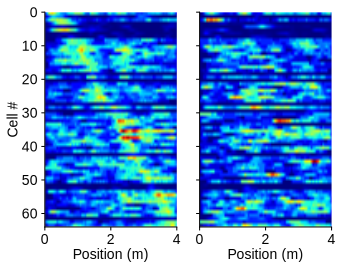

In [38]:
def display_tuning(tuning, ctx=np.array([0,1,0,1]), sort=0):
    
    nctx = len(set(ctx))
    tuning_mean = [[] for _ in range(nctx)]
    
    for c in range(nctx):
        M = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)  # (ncell,ybin,ntrial)
        tuning_mean[c] = M.mean(axis=2)
        
    fig, axs = plt.subplots(1,nctx,figsize=(5,4),sharey=True)
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    for c in range(nctx):
        axs[c].imshow(tuning_mean[c][order], cmap='jet', interpolation='none', 
                      extent=[0,4,ncell,0])
        axs[c].set_aspect('auto')
        axs[c].set_xlabel('Position (m)')
    axs[0].set_ylabel('Cells')
    fig.tight_layout()
    return fig
    
fig = display_tuning(tuning_, ctx=ctx, sort=0)
# fig.savefig('Test.svg')

## Trial-to-trial similarity

In [39]:
def trial_similarity(tuning, ctx=np.array([0,1,0,1]),
                     plot=True, vmax=1.0):
    '''
    Parameters
    ----------
    tuning : list (category) of arrays, shape (ncell,ybin,ntrial)
        Spatial tuning of each category for a given mouse
    '''
    ncat = len(ctx)
    tuning_bis = [tuning[k] for k in range(ncat)]  # The first few categories

    M = np.concatenate(tuning_bis, axis=2)  # Combine categories (ncell,ybin,ntrial)
    ncell, _, ntrial = M.shape
    M_ = M.reshape((-1, ntrial)).T
    R = cosine_similarity(M_)  # Nonnegative affinity matrix (0 to 1)
    
    if plot:
        fig, ax = plt.subplots(figsize=(5,4))
        img = ax.imshow(R, vmin=0, vmax=vmax)
        ax.set(xlabel='Run #', ylabel='Run #')
        ax.set_title(f'Similarity ({ncell} cells)')
        fig.colorbar(img, ax=ax)
        fig.tight_layout()
    
    return R

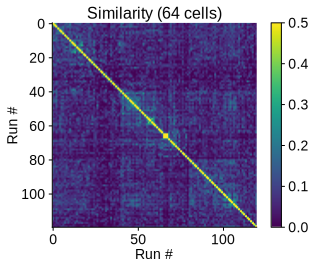

In [42]:
R = trial_similarity(tuning_, ctx=ctx, plot=True, vmax=0.5)